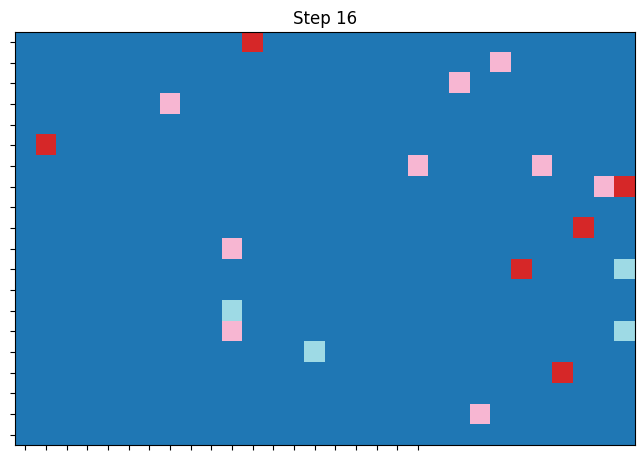

KeyboardInterrupt: 

In [1]:
import random
import numpy as np
import csv
import time
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns

# ===============================
# PARAMETRI DELLA SIMULAZIONE
# ===============================
M, N = 20, 30  # Dimensioni della griglia (righe x colonne)
MICE, CHEESE, CATS = 5, 10, 2  # Numero di topi, pezzi di formaggio e gatti
VISION_RANGE = 5  # Raggio di visione degli agenti
BETA = 2  # Fattore di repulsione
K = 100  # Numero di passi per simulazione
RANDOM_SEED = 42  # Per garantire la riproducibilità

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ===============================
# FUNZIONI DI SUPPORTO
# ===============================
def distance(x1, y1, x2, y2):
    """Calcola la distanza euclidea tra due punti."""
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def attraction_repulsion(dist, beta=1):
    """Calcola l'attrazione o la repulsione in base alla distanza."""
    if dist == 0:
        return 1e9  # Evita divisioni per zero
    return 1 / (dist * beta)

# ===============================
# CLASSE AGENTE (TOPO/GATTO)
# ===============================
class Agent:
    def __init__(self, x, y, agent_type, agent_id):
        """Inizializza un agente con posizione e tipo (topo o gatto)."""
        self.x = x
        self.y = y
        self.agent_type = agent_type
        self.agent_id = agent_id
        self.path = [(0, self.x, self.y, 0, 0)]  # Tracciamento del percorso
        self.cumulative_movement = 0  # Movimento cumulativo
        self.interaction_time = 0  # Tempo di interazione

    def move(self, grid, agents):
        """Gestisce il movimento dell'agente basato su attrazione/repulsione."""
        possibili_mosse = []
        best_value = -np.inf

        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                nx, ny = (self.x + dx) % M, (self.y + dy) % N
                value = self.calculate_value(nx, ny, grid, agents)

                if value > best_value:
                    best_value = value
                    possibili_mosse = [(dx, dy)]
                elif value == best_value:
                    possibili_mosse.append((dx, dy))

        if possibili_mosse:
            best_move = random.choice(possibili_mosse)
            prev_x, prev_y = self.x, self.y
            self.x = (self.x + best_move[0]) % M
            self.y = (self.y + best_move[1]) % N

            velocity = distance(prev_x, prev_y, self.x, self.y)
            self.cumulative_movement += velocity
            direction = np.arctan2(self.y - prev_y, self.x - prev_y)
            self.path.append((len(self.path), self.x, self.y, velocity, direction))

    def calculate_value(self, nx, ny, grid, agents):
        if self.agent_type == "mouse":
            return self.mouse_value(nx, ny, grid, agents)
        elif self.agent_type == "cat":
            return self.cat_value(nx, ny, grid, agents)
        return 0

    def mouse_value(self, nx, ny, grid, agents):
        best_cheese_value = -np.inf
        closest_cat_value = np.inf

        for cheese_x, cheese_y in np.argwhere(grid == 2):
            dist = distance(nx, ny, cheese_x, cheese_y)
            if dist <= VISION_RANGE:
                best_cheese_value = max(best_cheese_value, attraction_repulsion(dist))

        for agent in agents:
            if agent.agent_type == "cat":
                dist = distance(nx, ny, agent.x, agent.y)
                if dist <= VISION_RANGE:
                    closest_cat_value = min(closest_cat_value, attraction_repulsion(dist, BETA))

        return best_cheese_value - closest_cat_value

    def cat_value(self, nx, ny, grid, agents):
        best_mouse_value = -np.inf

        for agent in agents:
            if agent.agent_type == "mouse":
                dist = distance(nx, ny, agent.x, agent.y)
                if dist <= VISION_RANGE:
                    best_mouse_value = max(best_mouse_value, attraction_repulsion(dist))

        return best_mouse_value

# ===============================
# INIZIALIZZAZIONE AMBIENTE
# ===============================
def initialize_environment():
    grid = np.zeros((M, N))
    agents = []

    # Posizionamento formaggi
    for _ in range(CHEESE):
        x, y = np.random.randint(0, M), np.random.randint(0, N)
        while grid[x, y] != 0:
            x, y = np.random.randint(0, M), np.random.randint(0, N)
        grid[x, y] = 2

    # Posizionamento topi
    for i in range(MICE):
        x, y = np.random.randint(0, M), np.random.randint(0, N)
        while grid[x, y] != 0:
            x, y = np.random.randint(0, M), np.random.randint(0, N)
        grid[x, y] = 1
        agents.append(Agent(x, y, "mouse", i))

    # Posizionamento gatti
    for i in range(CATS):
        x, y = np.random.randint(0, M), np.random.randint(0, N)
        while grid[x, y] != 0:
            x, y = np.random.randint(0, M), np.random.randint(0, N)
        grid[x, y] = 3
        agents.append(Agent(x, y, "cat", MICE + i))

    return grid, agents

# ===============================
# SIMULAZIONE PRINCIPALE
# ===============================
def run_simulation(grid, agents):
    for step in range(K):
        for agent in agents:
            agent.move(grid, agents)
        # Visualizza la simulazione passo per passo
        display_simulation_step(grid, agents, step)

# ================================
# VISUALIZZAZIONE INTERATTIVA
# ================================
def display_simulation_step(grid, agents, step):
    """Visualizza la simulazione passo dopo passo."""
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks(np.arange(0, M, 1))
    ax.set_yticks(np.arange(0, N, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    # Crea una copia della griglia
    grid_display = np.copy(grid)

    # Posiziona le immagini dei topi e gatti sulla griglia
    for agent in agents:
        if agent.agent_type == "mouse":
            grid_display[agent.x, agent.y] = 1  # Topo
        elif agent.agent_type == "cat":
            grid_display[agent.x, agent.y] = 3  # Gatto

    # Mappa colori per visualizzare gli agenti sulla griglia
    cmap = plt.cm.get_cmap('tab20', 4)

    ax.imshow(grid_display, cmap=cmap, interpolation='nearest')

    # Mostra la visualizzazione del passo corrente
    ax.set_title(f"Step {step}")
    clear_output(wait=True)  # Rimuove la figura precedente
    display(fig)  # Mostra la nuova figura
    plt.close(fig)  # Chiude la figura per evitare accumulo di grafici
    time.sleep(0.5)  # Pausa di 0.5 secondi tra i passi per visualizzare il movimento

# ================================
# SALVATAGGIO DEI DATI IN CSV
# ================================
def save_data(agents, filename, run):
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for agent in agents:
            for step in agent.path:
                writer.writerow([run, agent.agent_id, agent.agent_type, step[0], step[1], step[2], step[3], step[4]])

# ================================
# MACHINE LEARNING
# ================================
def apply_ml_with_graph_tool():
    # Carica i dati dal CSV
    data = []
    with open('simulation_data.csv', 'r') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Salta l'intestazione
        for row in reader:
            data.append(row)
    data = np.array(data)

    # Estrazione delle caratteristiche comportamentali
    features = data[:, 4:6].astype(float)  # Esempio: velocità e direzione
    labels = np.array([1 if t == "cat" else 0 for t in data[:, 2]])  # Etichette: 1 = cat, 0 = mouse

    # SMOTE per bilanciare le classi
    smote = SMOTE(random_state=RANDOM_SEED)
    features_resampled, labels_resampled = smote.fit_resample(features, labels)

    # Split train/test
    X_train, X_test, y_train, y_test = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=RANDOM_SEED)

    # Creazione del modello Random Forest con pesatura delle classi
    rf = RandomForestClassifier(random_state=RANDOM_SEED, class_weight='balanced')

    # Addestramento del modello
    rf.fit(X_train, y_train)

    # Predizioni
    y_pred = rf.predict(X_test)

    # Calcolare le metriche
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Visualizzare la matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Mouse", "Cat"], yticklabels=["Mouse", "Cat"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# ================================
# ESECUZIONE SIMULAZIONE E ML
# ================================
# Inizializzazione
grid, agents = initialize_environment()

# Esegui la simulazione e raccogli i dati
for run in range(5):  # Esegui 5 simulazioni
    run_simulation(grid, agents)
    save_data(agents, 'simulation_data.csv', run)

# Applicazione del Machine Learning
apply_ml_with_graph_tool()
